In [1]:
import pandas as pd
import re

# Cleaning Functions

In [2]:
def clean_line_text(df):
    import re
    badChars = re.compile('[^A-Z \-?\.&\'\[\],*!\%]', re.I)
    df['line_text'] = df['line_text'].map(lambda x: badChars.sub('', x))
    return df

def clean_speaker_names(df):
    df['speaker'] = df['speaker'].str.strip().str.lower()
    return df

def drop_deleted_scenes(df):
    df = df[df['deleted'] == False]
    del df['deleted']
    return df.reset_index(drop=True)


In [3]:
def do_all_data_loading():
    df = pd.read_csv('data/the-office-lines-scripts.csv')
    df = clean_line_text(df)
    df = clean_speaker_names(df)
    df = drop_deleted_scenes(df)
    return df

### First Look at Data

In [4]:
df = do_all_data_loading()

In [5]:
df[df['line_text'].str.contains('Bears.  Beets.  Battlestar')]

,id,season,episode,scene,line_text,speaker
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim


##  EDA Functions

In [6]:
def line_search(line, speaker=None):
    if speaker:
        speaker = df['speaker'] == speaker
    else:
        speaker = True

    line = line.replace(' ', '\s*')
    line = df['line_text'].str.contains(line, regex=True, flags=re.I)

    return df[line & speaker]

In [7]:
line_search('bears. beets. battlestar')

,id,season,episode,scene,line_text,speaker
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim


In [8]:
def get_dialogue(season, episode, scenes=None):
    season = df['season'] == season
    episode = df['episode'] == episode

    if scenes:
        if type(scenes) != list:
            scenes = [scenes]
        else:
            scenes = list(range(*scenes))

        scenes = df['scene'].isin(scenes)
    else:
        scenes = True

    return df[season & episode & scenes]

In [9]:
get_dialogue(season=3, episode=20, scenes=[1, 3])

,id,season,episode,scene,line_text,speaker
13405,15342,3,20,1,[Dressed as Dwight] It's kind of blurry. [puts...,jim
13406,15343,3,20,1,That's a ridiculous question.,dwight
13407,15344,3,20,1,False. Black bear.,jim
13408,15345,3,20,1,Well that's debatable. There are basically tw...,dwight
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim
13410,15347,3,20,1,Bears do not--- What is going on--- What are y...,dwight
13411,15348,3,20,2,"Last week, I was in a drug store and I saw the...",jim


## Actually Doing EDA

#### Who's considreed to be core cast?

In [10]:
len(df['speaker'].unique())

771

In [11]:
def filter_cast(df, minLines=100):
    lineCounts = df['speaker'].value_counts()
    importantPeople = lineCounts[lineCounts > minLines].index

    filtered = df[df['speaker'].isin(importantPeople)]

    return filtered.reset_index(drop=True)

In [12]:
filteredCast = filter_cast(df, 250)

filteredCast['speaker'].unique()

array(['michael', 'jim', 'pam', 'dwight', 'jan', 'phyllis', 'stanley',
       'oscar', 'angela', 'kevin', 'ryan', 'toby', 'kelly', 'meredith',
       'darryl', 'creed', 'david', 'andy', 'karen', 'holly', 'erin',
       'gabe', 'clark', 'robert', 'nellie'], dtype=object)

#### Who shares the screen the most?

In [13]:
gb = filteredCast.groupby(['season', 'episode', 'scene'])
s = gb['speaker'].unique().reset_index(drop=True)

sceneByCast = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)

sceneByCast = sceneByCast[sceneByCast.sum(axis=1) > 1]

In [14]:
sceneByCast[sceneByCast['andy'] > 0].sum()

andy        1042
angela       142
clark         21
creed         57
darryl       138
david          9
dwight       332
erin         230
gabe          37
holly          9
jan            9
jim          317
karen         20
kelly         84
kevin        203
meredith      95
michael      225
nellie        35
oscar        167
pam          220
phyllis      179
robert        57
ryan          74
stanley      131
toby          39
dtype: int64

In [15]:

pairs = {char:None for char in sceneByCast}

for char in sceneByCast:
    pairs[char] = sceneByCast[sceneByCast[char] > 0].sum()

In [16]:
pairValues = pd.DataFrame(pairs).values
pairValues

array([[1042,  142,   21,   57,  138,    9,  332,  230,   37,    9,    9,
         317,   20,   84,  203,   95,  225,   35,  167,  220,  179,   57,
          74,  131,   39],
       [ 142,  657,    8,   46,   34,    0,  280,   61,   14,    9,   16,
         133,   15,   83,  210,   86,  178,   26,  199,  186,  146,   11,
          33,   76,   42],
       [  21,    8,   79,    3,   12,    0,   47,   13,    0,    0,    1,
          15,    0,    0,   12,    9,    0,    5,   11,   16,   10,    0,
           0,   11,    3],
       [  57,   46,    3,  222,   16,    2,   81,   28,   10,    3,    3,
          83,    3,   31,   63,   44,   79,   13,   57,   74,   57,    5,
          29,   43,   26],
       [ 138,   34,   12,   16,  382,    0,   95,   39,   29,   20,    1,
          91,    2,   32,   89,   34,  110,   21,   67,   77,   62,    7,
          23,   32,   32],
       [   9,    0,    0,    2,    0,   84,   19,    4,    0,    2,    8,
          21,    2,    3,    2,    3,   58,    1,  

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\nhounshell\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['char']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


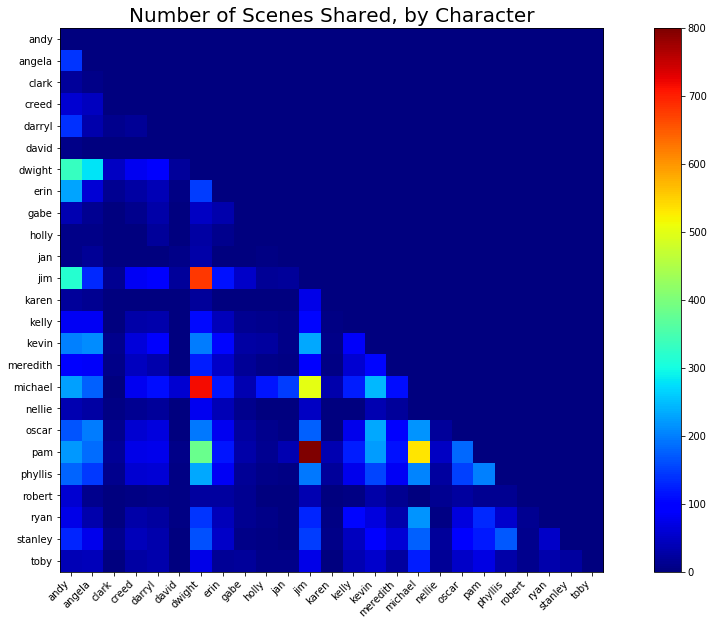

In [18]:
fig, ax = plt.subplots(figsize=(18, 10))


im = ax.imshow(np.tril(pairValues, k=-1), cmap='jet')
ax.figure.colorbar(im)

_ = ax.set_xticks(np.arange(len(pairs)))
_ = ax.set_yticks(np.arange(len(pairs)))

_ = ax.set_xticklabels(pairs, rotation=45, ha='right')
_ = ax.set_yticklabels(pairs)

_ = ax.set_title('Number of Scenes Shared, by Character', size=20)


### Who Swears the most?

In [19]:
line_search('\*')['speaker'].value_counts()

michael     2
kevin       2
jo          1
toby        1
ryan        1
kelly       1
phyllis     1
andy        1
darryl      1
deangelo    1
pam         1
robert      1
oscar       1
brandon     1
Name: speaker, dtype: int64

## Who sets Michael up the most?

In [20]:
df.loc[line_search('what she said').index - 1]['speaker'].value_counts()

michael         11
jim              5
lester           4
dwight           2
jan              2
kevin            1
darryl           1
gabe             1
pam              1
phyllis          1
doctor           1
andy             1
angela           1
holly            1
kelly            1
clark            1
david            1
second cindy     1
Name: speaker, dtype: int64

In [21]:
df.loc[line_search('what she said').index - 1]

,id,season,episode,scene,line_text,speaker
1962,2544,2,2,24,"No, thanks. I'm good.",jim
2008,2590,2,2,34,"Attention, everyone! Hello! Ah, yes! I just wa...",michael
2011,2593,2,2,34,Wow! That is really hard. You really think you...,jim
4089,5324,2,10,2,[holds up the piece of tree he just cut off wi...,kevin
4941,6321,2,12,33,Does the skin look red and swollen?,doctor
6025,7643,2,17,5,I have a ton of stuff to do for the wedding. A...,pam
7043,8871,2,21,22,You already did me.,angela
7721,9623,3,1,48,We are not in the playground anymore. There a...,michael
9001,10903,3,5,59,"I mean, they're just dough twisted up with som...",michael
10691,12593,3,10,49,"Thanks! I, I wanna give you something.",second cindy


In [22]:
get_dialogue(4, 8, 23)

,id,season,episode,scene,line_text,speaker
18328,20265,4,8,23,How long have you known the plaintiff?,lester
18329,20266,4,8,23,I haven't actually seen it. But I have seen th...,michael
18330,20267,4,8,23,How long have you known Ms. Levinson?,lester
18331,20268,4,8,23,Six years and two months.,michael
18332,20269,4,8,23,And you were directly under her the entire time?,lester
18333,20270,4,8,23,That's what she said.,michael
18334,20271,4,8,23,Excuse me?,lester
18335,20272,4,8,23,That's what she said.,michael
18336,20273,4,8,23,Ms. Levinson told you she was your direct supe...,lester
18337,20274,4,8,23,"Uh, wh-why would she say that?",michael
